## Analysis of Hollywood Evolution

How does the hollywood network look like and how has it changed over time

In this section we will dive into the network and explore different attributes of the network such to gain an insight into the elite of hollywood. This will be structured into the 6 subsections listed below.

* Investigation of the network - Get at reference point to some of the well known and documented networks
    * [x] Links
    * [x] In and out degree
    * [x] Visualisation of the entire network with relevant attributes - SHOULD BE IMPROVED
    * [ ] Comparison with Random Network
    * [ ] Changes in degree distribution over time
    
* Genre - How are the top of hollywood distributed across genres
    * [x] Genre distribution over time
    * [x] Genre popularity compared to average budget
    * [ ] Particular patterns of actors work in genres - Asbjørn

* Important words - What words stand out using TF-IDF schemas of the decades and across genres and decase
    * [x] TF-IDF
    * [x] Relation to dominant genres
    * [x] Wordclouds
    * [ ] Most important words -> similarity with the decades wikipedia page

* Sentiment - How do people interpet the words of these segmentations?
    * [ ] How does it relate to the TF-IDF
    * [ ] Does it reflect the major events of the us/world?

* Actor communities - What actors constitute movie communities and how has this changes over time?
    * [ ] Are the communities high budget highly rated?

* Wrapup - Can we generalize the trends in hollywood?


In [107]:
#Imports
from IPython.display import Image, clear_output
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import re
import nltk
import json
import bar_chart_race as bcr
import random
from fa2 import ForceAtlas2
import json
from collections import Counter, defaultdict
import urllib
from datetime import datetime
from ipywidgets import *
import ipywidgets as widgets
import time
import math
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
import seaborn as sns
from pandas.core.common import SettingWithCopyWarning
import warnings
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

#import gif
import sys
sys.path.append('./jupyter')
from helpers import create_df_G_from_path


#Init stopwords
stop_words = set(stopwords.words('english'))

In [108]:
path = r'C:\Users\bilto\OneDrive\Uddannelse\Skole\DTU\02805 - Sociale Grafer og interaktioner\Afleveringer\\'

In [109]:
df, G = create_df_G_from_path(path)

### Network investigation
To gain deeper insight into our network we will start off by letting the data talk

In [110]:
# ANALYSIS
print(f"Number of nodes in network: {G.number_of_nodes()}")
print(f"Number of links (edges) in network: {G.number_of_edges():,}")
print(f"Average number of links per node: {round(G.number_of_edges()/G.number_of_nodes(),2)}")
print(f"Average shortest path: {round(nx.algorithms.average_shortest_path_length(G),4)}")

Number of nodes in network: 500
Number of links (edges) in network: 18,178
Average number of links per node: 36.36
Average shortest path: 1.8571


In [111]:
in_degree = sorted([(d,n) for n, d in G.degree()], reverse=True)
print('Top 5 most connected characters (movies, Actor)')
print(*in_degree[0:5], sep='\n')

Top 5 most connected characters (movies, Actor)
(176, 'Samuel L. Jackson')
(148, 'Owen Wilson')
(143, 'Bruce Willis')
(142, 'John C. Reilly')
(141, 'Steve Buscemi')


From the above we see that the network is very highly connected with every node on average connecting to a 36.44 characters and an average shortest path only being 1.85.

<b> The small world phenomonon </b> <br>
The small world phenomonon, known as six degrees of separation, refers to the fact that: <i> "two individuals, anywhere in the world, can be connected through a chain of six or fewer acquaintances" </i>[\[1\]](http://networksciencebook.com/chapter/3#small-worlds). By this measure, Hollywood is surely a small world...

From the data it looks like the actors are contributing to a very similiar amount of movies, which could lead one to believe that the network amongst the top 500 does not follow a **power law distribution** 

Lets take a look at the degree distribution along with the productivity over time for the actors

In [112]:
# Degree
degree = sorted(G.degree, key=lambda x: x[1], reverse=True)
# Splitting the sequence
degree_sequence = sorted([d for n, d in degree], reverse=True)
# Creating the histogram bins and counts
hist, bin_edges = np.histogram(np.array(degree_sequence), bins=np.arange(degree[-1][1], degree[0][1]+2))

# For the barplot
degreeCount = Counter(degree_sequence) # Count the degrees
deg, cnt = zip(*degreeCount.items()) # deg: degree, cnt: the count of the degree


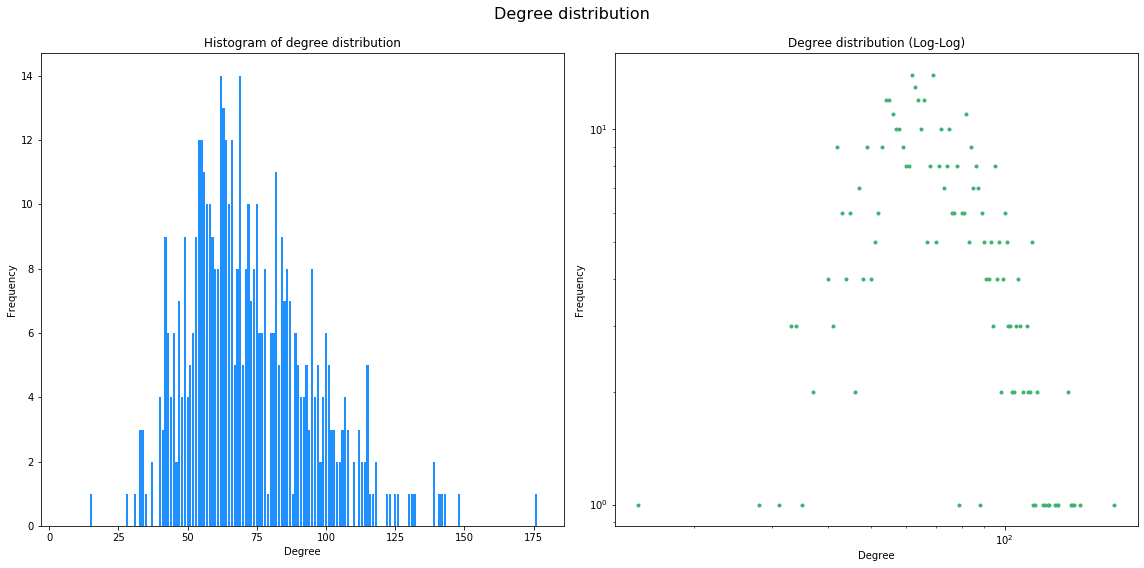

In [113]:
# Plot:
fig, axarr = plt.subplots(1, 2, figsize=(16,8))
fig.suptitle("Degree distribution", fontsize=16)

axarr[0].bar(deg,cnt,color='dodgerblue')
axarr[0].set_xlabel('Degree')
axarr[0].set_ylabel("Frequency")
axarr[0].set_xlim([-3,max(deg)+10])
axarr[0].set_title("Histogram of degree distribution")

axarr[1].loglog(bin_edges[:-1],hist,'.', color="mediumseagreen")
axarr[1].set_xlabel('Degree')
axarr[1].set_ylabel("Frequency")
axarr[1].set_title("Degree distribution (Log-Log)")

fig.tight_layout()
fig.subplots_adjust(top=0.9)
plt.show()

<b> The degree distribution </b> <br>
The degree distribution tells us the distribution of how many actors each actor is connected to. We see that it definitely does not follow a power law distribution. Rather, it looks more like a skewed normal distribution centered at around 65 <br>

<u> Thoughts on distribution </u> <br>
Recall (refer to <a href=""> this section </a>) that this network was created by extracting the <b> top </b> 500 actors from the dataset and creating a network out of that. This in turn means that all the "low" degree actors was left out on purpose. It is certainly plausible that the original network is following a power law distribution since there are a lot of actors who have only starred in 1 movie.

Let us understand the actor productivity a little better

In [114]:
'''
Create a reverse lookup: Mapping from movie -> release date
'''
reverse_movie_year_lookup={}
for i, row in df.iterrows():
    if pd.isna(row['release_date']): #movies without a release date
        continue
    reverse_movie_year_lookup[row['original_title']] = row['release_date']

'''
For each actor, look up the release date of every movie they have been in.
Store the result as a list of tuples, t = (actor, [year1, year2, ..., yearN])
'''
#Extract data
release_data = []
for node in G.nodes:
    actor_movies = sorted([reverse_movie_year_lookup[x].year for x in G.nodes[node]['movies']])
    first_release = min(actor_movies)
    release_years_relative = [x-first_release for x in actor_movies]
    release_data.append((node, release_years_relative))
    
    
#sort the release data by most releases
release_data = sorted(release_data, key=lambda x: len(x[1]), reverse=True)

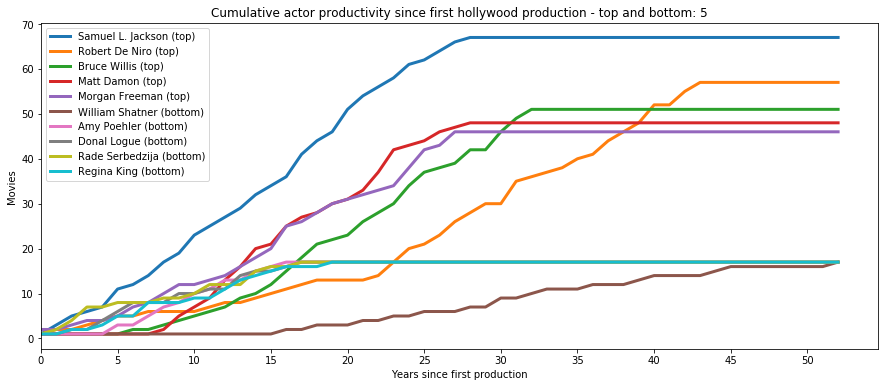

In [115]:
n = 5 #Number of actors to plot

max_ = max([max(x[1]) for x in release_data[:n] + release_data[-n:]])+1 #max years an actor has been producing


fig, ax = plt.subplots(figsize=(15, 6))

#Top actors
for actor, releases in release_data[:n]:
    x = np.arange(0, max_)
    
    unique, counts = np.unique(releases, return_counts=True)
    d = dict(zip(unique, counts))
    y = np.cumsum([d[x] if x in d.keys() else 0 for x in range(max_)])
    ax.plot(x, y, label=actor + " (top)",linewidth=3)

#Bottom actors
for actor, releases in release_data[-n:]:
    x = np.arange(0, max_)
    
    unique, counts = np.unique(releases, return_counts=True)
    d = dict(zip(unique, counts))
    y = np.cumsum([d[x] if x in d.keys() else 0 for x in range(max_)])
    ax.plot(x, y, label=actor + " (bottom)",linewidth=3)



ax.set_xlim(0)
ax.set_xticks(np.arange(0,max_, 5))
ax.set_ylabel('Movies')
ax.set_xlabel('Years since first production')
plt.title(f'Cumulative actor productivity since first hollywood production - top and bottom: {n}')
plt.legend(loc = 'upper left')
plt.show()

The plot of actor productivity seems to tell the story that even between **the top 500 Actors** there are quite a big difference in productivity between the top and bottom. Samuel L. Jackson has produced around 20 movies pr. decade while William Shatner produces around 6 in the first 20 years. William Shatner has, however, had the longest career of +50 years!

Furthermore, there seems to be a <u> trend in the productivity of the actors and actresses </u>:
* They are largely unproductive in their first five years of their career
* They are most productive between year 10 and 20 of their career
* They productivity seems to fade after around 20-25 years in the business

Now that we have a basic understanding of the network, let us try to visualize the network to get an overview

### Visual representation of the network

Let's take a look at the full network sizing the actors after productivity, coloring after most common genre, and letting opacity of edges reflect how much two actors have worked together

In [116]:
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs
                        edgeWeightInfluence=0.6,

                        # Performance
                        jitterTolerance=0.15,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=0.7,

                        # Tuning
                        scalingRatio=4.0,
                        strongGravityMode=True,
                        gravity=1.0,

                        # Log
                        verbose=True)

In [ ]:
from matplotlib import colors as mcolors

In [272]:
warnings.simplefilter('ignore')
def weight_color_map(weight, inverse_color=False):
    '''
    Function to weight the edges
    '''
    inv_fac=0
    if inverse_color:
        inv_fac=1
    get_tuple = lambda x: tuple(abs(inv_fac-x) for y in range(3))
    
    # Low weight edge
    if weight<2:
        
        #white
        if not inverse_color:
            (1,0,0)
        return get_tuple(0.9)
    # Mid weight edge
    elif weight <5:
        
        return get_tuple(0.6)
    # mid-high weight edge
    elif weight <7:
        # Green
        return (0.3, 0.8, 0)
    # High weight edge
    else:
        # Dark red
        return (1, 0, 0)
    
    
def plot_graph(G, actor_label_movie_limit=40, inverse_color=False, node_cmap = None):
    color_map = {}
    
    if node_cmap is None:
        for genre in list(set([G.nodes[x]['top_genre'] for x in list(G.nodes)])):
            color_map[genre] = []

        for node in G.nodes:
            color_map[G.nodes[node]['top_genre']] += [node]
    fig, ax = plt.subplots(figsize=(18,16))

    positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=5)
    
    color = {'Action': 'Red', 'Adventure': 'Blue', 'Animation': 'Pink', 'Comedy': 'Green', 'Crime': 'Brown',\
          'Drama': 'Cyan', 'Family': 'Yellow', 'Thriller' : 'White', 'Romance': 'Orange', 'Science Fiction': 'Black'}
    # Inverse
    node_label_color = 'black'
    if inverse_color:
        node_label_color='white'

    ''' Plotting option if plotting communities '''
    if node_cmap == 'community':
        color_map = {}
        for community in list(set([G.nodes[x]['community'] for x in list(G.nodes)])):
            color_map[community] = []

        for node in G.nodes:
            color_map[G.nodes[node]['community']] += [node]
        
        m_colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
        n = 30
        n1 = np.arange(n)
        color = dict(zip(n1, list(m_colors.keys())[:n]))    
        
    
    for key in color_map.keys():
        nx.draw_networkx_nodes(G,pos=positions,nodelist=color_map[key],\
            node_size=[int(G.nodes[x]['movies_count'])*2 for x in color_map[key]], node_color=color[key], label=key, ax=ax)
    
    colormap_edges = [weight_color_map(G[u][v]['weight'], inverse_color) for u,v in G.edges]
    nx.draw_networkx_edges(G, positions, edge_color=colormap_edges, alpha=0.4, ax = ax,width=2)
    ax.legend(scatterpoints = 1)
    nx.draw_networkx_labels(G, positions,{y:'' if G.nodes[y]['movies_count']<actor_label_movie_limit else y for y in positions.keys()}, font_size=14, font_color=node_label_color, ax = ax)
    ax.axis('off')
    title_obj = ax.set_title('Top 500 Actors \n Colored after most common genre, sized after total feature films')
    plt.setp(title_obj, color='white') 
    plt.setp(title_obj, fontsize=15) 

    if inverse_color:
        ax.set_facecolor('black')
        fig.set_facecolor('black')
    return ax

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 161.53it/s]


BarnesHut Approximation  took  0.00  seconds
Repulsion forces  took  0.02  seconds
Gravitational forces  took  0.00  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.00  seconds


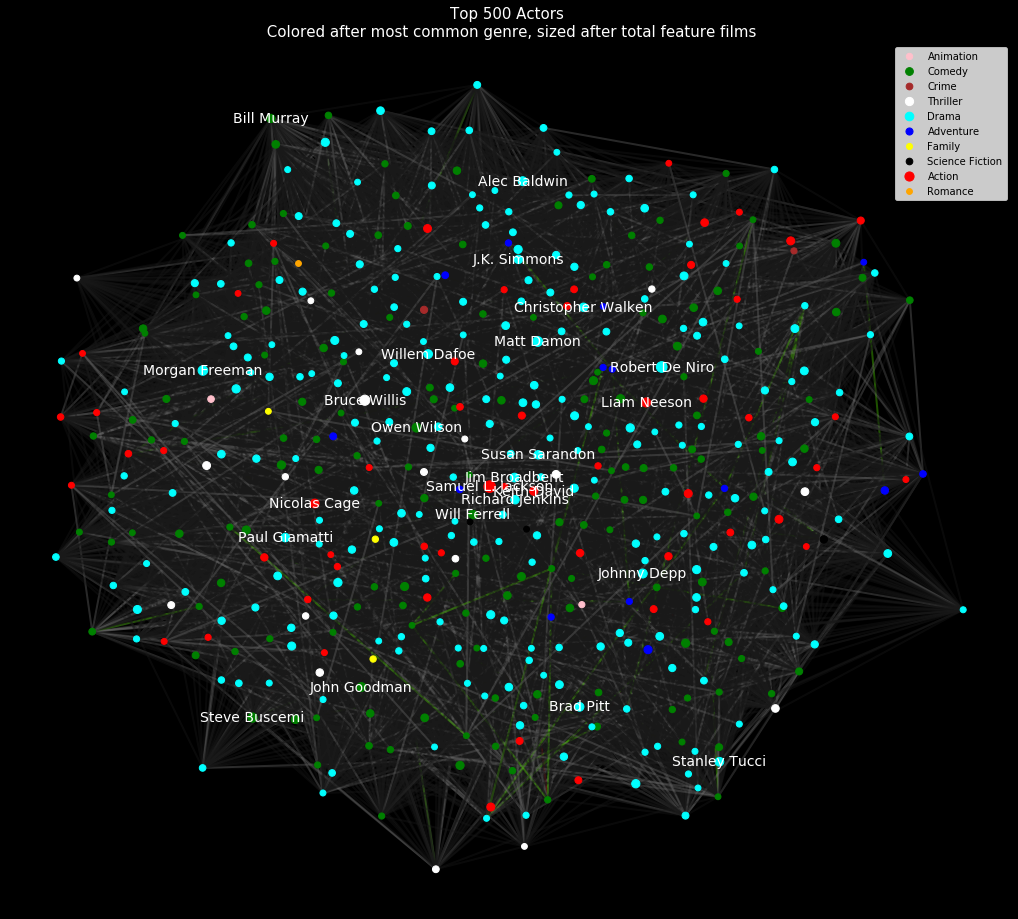

In [273]:
ax = plot_graph(G, actor_label_movie_limit=35, inverse_color=True)

plt.show()

From the above plot we see that there seem to be an overweight of actors acting within the genres of comedy, action and drama. <br> 

The high connection degree makes it difficult to see what is going on, but we see that there are definitely some central nodes in the network.

<br>
<u> Let's try and look into whether some of these actors can be split into communities </u>

## Actor Communities

As presented in project assignment A, we have a theory that there exist small communities within Hollywood, where groups of actors do the majority of their work together in specific genres. The reasoning behind this is that e.g. typical action movie actors often end up starring together, simply because they prefer the same genre. <br>

In general terms, this section will uncover the communities of Hollywood, and investigate whether communities are genre dependent. 

To find the communities it has been chosen to use the Louvain algorithm. The following section will elaborate on why we've chosen this algorithm in particular.

<b>Modularity</b>

Before diving into the Louvain algorithm, we must understand what it tries to partition the graph on. Modularity is a measure of how connected a group of nodes are, compared to how connected they're expected to be. The formula for modularity is given by:

$$M = \sum_{n=0}^{n_c} \left[ \frac{L_c}{L} - \frac{k_c}{2L}^2 \right]$$

$L = $ Total number of links,
$L_c = $ Number of links in community $c$,
$n_c = $ Number of communities,
$k_c = $ Total degree of the community $c$.

If we remove the sum, and thus only investigate the modularity of 1 community, we can that a community gets a high modularity score, if they are 1) very connected to one another, and 2) not very connected to nodes outside the community. With expectation is meant, how connected we expect 2 nodes to be, if the network is randomly wired.

In our case, having a weighted graph, $L_c$ will be equal to the sum of weights inside community $c$, whereas $L$ will be equal to the total sum of weights in the whole network.

<b>Louvain Algorithm</b>

Having covered modularity, it seems reasonable to choose communities by maximixing modularity. Finding a best partition of a graph is by nature a hard problem, but the Louvain algorithm uses approximation and gives a running time of $O(L)$.

In simple terms, the louvain algorithm initially finds, for each node, the "best" neighboor with regards to modularity, that is, connecting to the node that causes the largest positive change in modularity, $\Delta M$. We do this repeatedly, until $\Delta M = 0$. Then the nodes in a community are merged into 1 node, with all their internal edges as self-loops, and the whole process is continuously repeated, until $\Delta M = 0$.

The order in which we consider the nodes are non-deterministic. This an greedy method, because optimizing the modularity locally, by finding the best neighboor, is not guaranteed to give the best result globally. However, the algorithm is very popular, because it often finds a satisfactory partition, and because it is very fast.

<b>Modularity and Resolution Limit</b>

Maximizing modularity will have difficulties finding communities smaller than the resolution limit, which is given by the formula:

$$k \leq \sqrt{2L}$$

In our case, this means, with our $L = 22415$, that we are going to have communities of  approximately size $212$. It is very hard to say something general about a network of actors of this size and we will thus enforce smaller communities. This is done by treating each community as a network itself, and then running the algorithm on this subgraph. Implementation-wise this magic has been done for us, where resolution is provided as a tuneable hyperparameter of the Louvain algorithm.

### Community Detection

In this section we will detect our communities, and do so by forcing smaller communities than the resolution limit.

In [119]:
import community as community_louvain
import networkx.algorithms.community as nx_comm

In [120]:
def get_modularity(community_dict):
    comvalues = np.array(list(community_dict.values()))
    comkeys = np.array(list(community_dict.keys()))
    
    
    l = []
    
    for i in np.unique(comvalues):
        comkey_indices = np.where(comvalues == i)[0]
        l1 = set()
        for j in comkey_indices:
            l1.add(comkeys[j])
        l.append(l1)
        
    return nx_comm.modularity(G, l)

<b>Choosing the resolution</b>

We explore the modularity as a function of resolution. From this we pick a suitable resolution, which yields satisfactory community sizes.

As previously stated, we use the Louvain algorithm.

In [121]:
def get_best_coms(Graph):
    best_mod = -2
    res = np.linspace(10**-1, 0.7, num=20)
    mod_scores = []
    best_res = res[0]
    for i in res:
        new_mod = get_modularity(community_louvain.best_partition(Graph, resolution=i, random_state = 1244))
        mod_scores.append(new_mod)
        if new_mod > best_mod:
            best_mod = new_mod
            best_res = i
    
    return res, mod_scores, community_louvain.best_partition(Graph, resolution=best_res, random_state = 1244)

In [122]:
Res, mod_Scores, com_dict = get_best_coms(G)

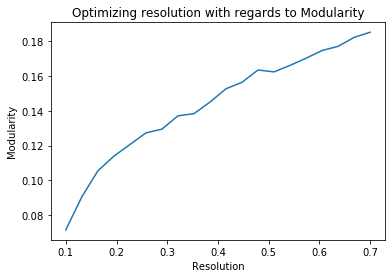

In [123]:
plt.plot(Res, mod_Scores)
plt.xlabel('Resolution')
plt.ylabel('Modularity')
plt.title('Optimizing resolution with regards to Modularity')
plt.show()

<b>Analyzing performance</b>

We notice that we have a modularity score of 0.18, when choosing a resolution of $0.7$. This is not an impressive modularity score, which questions the suitability for community detection on our network. <br> By using the Louvain algorithm, we force each node to be part of exactly 1 community. Considering e.g. Samuel L. Jackson, having starred with 176/500 of the actors in the network, it seems unreasonable to force him into one small actor community, and this will be the case for many actors.

<b> The plausibility of multiple communities </b> <br>
It seems likely that these top 500 actors are in fact part of multiple communities in Hollywood. Using e.g. link clustering would remove the one-community constraint, which might is arguably a reasonable choice in our case.

Before concluding our communities are of poor quality, we will investigate how many strong communties there are. A strong community is defined in the book as:

> $C$ is a strong community if each node within $C$ has more links within the community than with the rest of the graph. Specifically, a subgraph $C$ forms a strong community if for each node $i ∈ C$,  $k_i^{int}(C)> Ck_i^{ext}(C)$.

In [124]:
#Add community as node attribute
nx.set_node_attributes(G, com_dict, "community")

In [131]:
#Dataframe with communities
com_df = pd.DataFrame.from_dict(com_dict, orient='index')
com_df.rename({0:'community'}, axis=1, inplace=True)

In [132]:
com_df.head(2)

,community
Samuel L. Jackson,0
Robert De Niro,1


In [134]:
communities = com_df['community'].unique()

We now check whether the communities are strong

In [135]:
#Lopp communities
for i in communities:
    for j in G.subgraph(com_df[com_df['community']==i].index).nodes():
        Strong = True
        inside_edges = G.subgraph(com_df[com_df['community']==i].index).degree(j, weight='weight')
        total_edges = G.degree(j, weight='weight')
        
        if inside_edges < 0.5*total_edges:
            print("Community {} is NOT strong".format(i))
            Strong = False
            break
    
    if Strong:
        print("Community {} IS strong".format(i))

Community 0 is NOT strong
Community 1 is NOT strong
Community 2 is NOT strong
Community 3 is NOT strong
Community 4 is NOT strong
Community 5 is NOT strong
Community 6 is NOT strong
Community 7 is NOT strong
Community 8 is NOT strong
Community 9 is NOT strong
Community 10 is NOT strong
Community 11 is NOT strong
Community 12 is NOT strong
Community 13 is NOT strong
Community 14 is NOT strong
Community 15 is NOT strong
Community 16 is NOT strong
Community 17 is NOT strong
Community 18 is NOT strong


Unfortunately, this supports our theory that assigning each actor to 1 community is maybe not reasonable in our case. We will now test whether there are at least some weak communities, defined as:

> $C$ is a weak community if the total internal degree of a subgraph exceeds its total external degree. Specifically, a subgraph $C$ forms a weak community if $\sum_{n∈C}k_i^{int}(C)>\sum_{n∈C}k_i^{ext}(C)$.

We now check whether the communities are weak

In [136]:
for i in communities:
    int_degree = G.subgraph(com_df[com_df['community']==i].index).size(weight='weight')
    total_ext_degree = 0
    for j in G.subgraph(com_df[com_df['community']==i].index).nodes():
        Weak = True
        total_ext_degree += G.degree(j, weight='weight')
        
        if int_degree < 0.5*total_ext_degree:
            print("Community {} is NOT weak".format(i))
            Weak = False
            break
    
    if Weak:
        print("Community {} IS weak".format(i))

Community 0 is NOT weak
Community 1 is NOT weak
Community 2 is NOT weak
Community 3 is NOT weak
Community 4 is NOT weak
Community 5 is NOT weak
Community 6 is NOT weak
Community 7 is NOT weak
Community 8 is NOT weak
Community 9 is NOT weak
Community 10 is NOT weak
Community 11 is NOT weak
Community 12 is NOT weak
Community 13 is NOT weak
Community 14 is NOT weak
Community 15 is NOT weak
Community 16 is NOT weak
Community 17 is NOT weak
Community 18 is NOT weak


<b>Not a good partition</b>

We can now conclude that the partition is not very good, since we do not even have weak communities. Naturally we will need to keep this in mind, when we analyze the communities.

<b>Genre Based communities</b>

Having detected our communities, even though they are of somewhat poor quality, we now wish to investigate whether these are communties are strongly dependent on genre. Recall the hypothesis that e.g action actors star together often simply because they have the same genre preference, and thus often end up as co-stars.

In [137]:
def get_genre_bar(community):
    '''
    Calculate genre distribution for a community
    '''
    genre_summed = Counter()
    for i in G.subgraph(com_df[com_df['community']==community].index).nodes:
        genre_summed += G.nodes[i]['genre']
        
    norm = np.sum(np.array(list(genre_summed.values())))
    
    return np.array(list(genre_summed.keys())), np.array(list(genre_summed.values()))/np.sum(np.array(list(genre_summed.values())))

In [82]:
#Rename 
com_df['n_actors']=1
com_df = com_df.rename(columns = {0:'community'})
com_df_1 = com_df.groupby('community').sum()

In [151]:
#Add genres
genre_set = set()

for i in df.index:
    dict_ = json.loads(df['genres'].loc[i])
    for j in dict_:
        genre_set.add(j['name'])

In [152]:
for i in genre_set:
    print(i)

History
Documentary
Animation
Comedy
War
Foreign
Crime
Thriller
Drama
Western
TV Movie
Adventure
Mystery
Fantasy
Horror
Family
Music
Science Fiction
Action
Romance


In [153]:
for i in genre_set:
    com_df_1[i] = 0

In [154]:
for i in com_df_1.index:
    genres, count = get_genre_bar(i)
    idx = 0
    for j in genres:
        com_df_1[j].loc[i] = count[idx]
        idx += 1

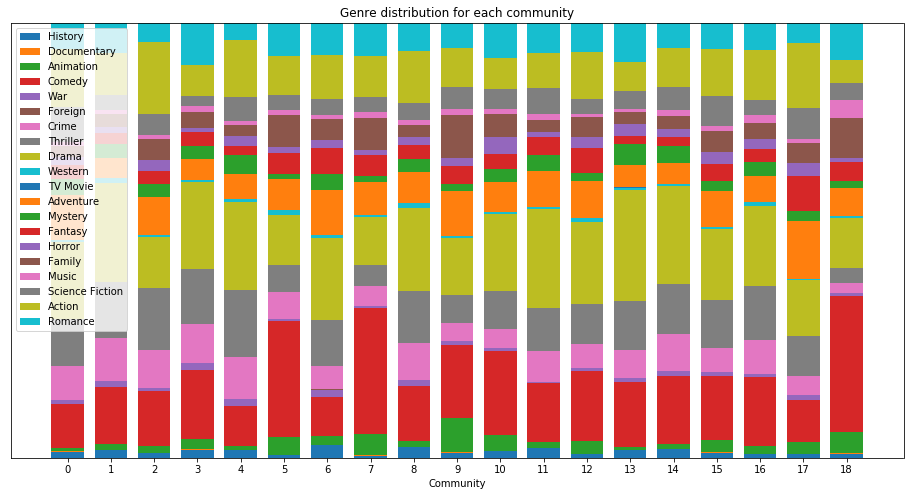

In [155]:
fig, ax = plt.subplots(figsize = (16,8))

r = np.arange(len(com_df_1))
barwidth = 0.75
bottom_ = np.zeros(len(com_df_1))

for i in com_df_1.drop('n_actors',axis=1).columns:
    bar = com_df_1[i].values
    plt.bar(r, bar, bottom=bottom_, width=barwidth, label=i)
    bottom_ = np.add(bottom_, bar).tolist()

plt.ylim(0,1)
ax.set_xticks(com_df_1.index)
ax.set_xlabel('Community')
ax.yaxis.set_visible(False)
plt.legend()
plt.title('Genre distribution for each community')
plt.show()

From this plot we see that actors in communities work with one another <b>across</b> genres. This was unexpected, since we had a theory that these communties would be strongly dependent on genre preferences of the actors inside the communities.

<b> Plot the communities </b> <br>
To verify our results, we try to visualize the communities below

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 161.48it/s]


BarnesHut Approximation  took  0.01  seconds
Repulsion forces  took  0.02  seconds
Gravitational forces  took  0.00  seconds
Attraction forces  took  0.01  seconds
AdjustSpeedAndApplyForces step  took  0.00  seconds


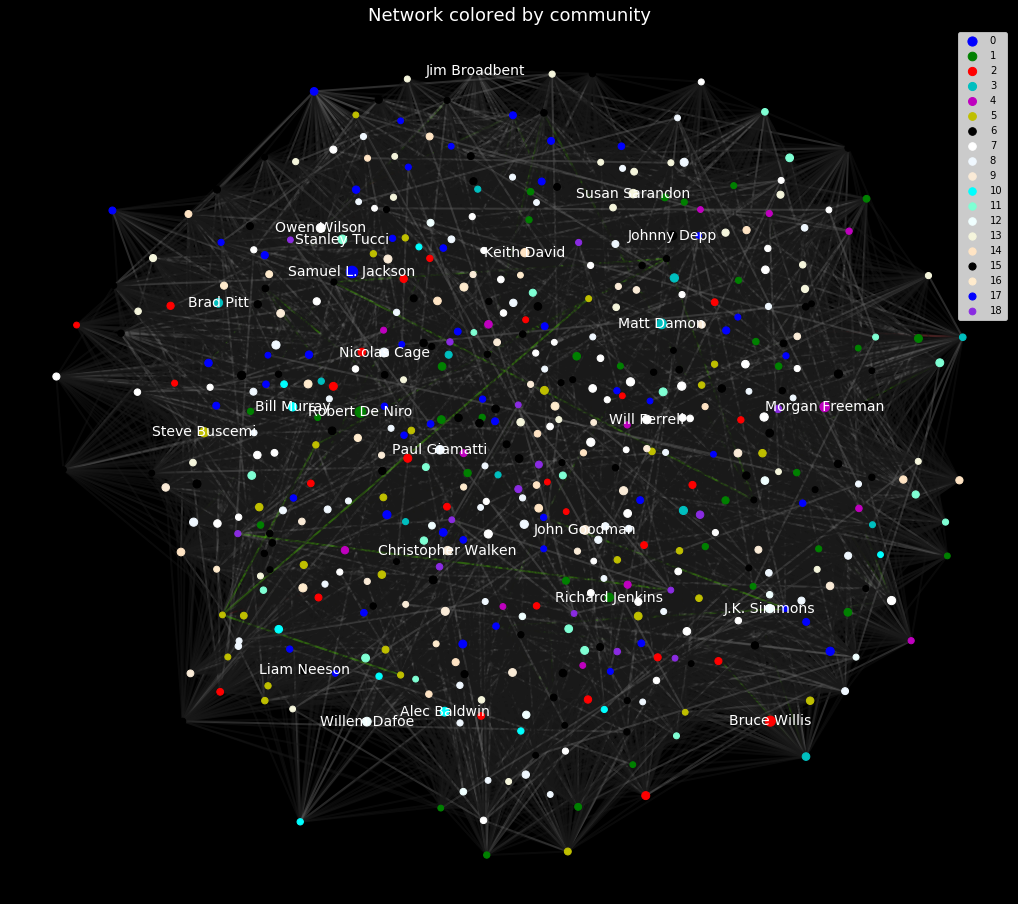

In [259]:
ax = plot_graph(G, actor_label_movie_limit=35, inverse_color=True, node_cmap = 'community')
plt.title('Network colored by community', fontsize = 18)
plt.show()

In [260]:
communities = list(set([d['community'] for x,d in G.nodes(data=True)]))
print(communities)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]


In [274]:
def get_community_nodes(community):
    return [x for x,d in G.nodes(data=True) if d['community'] == community]

In [275]:
print("Average shortest paths of each community")
for com in communities:
    nodes = get_community_nodes(com)
    print(com, "{:.2f}".format(nx.average_shortest_path_length(G.subgraph(nodes))))

Average shortest paths of each community
0 1.41
1 1.67
2 1.51
3 1.33
4 1.42
5 1.59
6 1.67
7 1.56
8 1.78
9 1.60
10 1.58
11 1.46
12 1.18
13 1.67
14 1.38
15 1.39
16 1.29
17 1.55
18 1.17


Recall that the average shortest path in the network was around 1.8 - All of the above communities have an average shortest path length less than than. That indicates that the actors from the communities are more likely to have worked together which makes sense. However, the average SP length is not as low as expected (e.g close to $1$)

<b> What drives the communities? </b> <br>
It seems that the actor communities are not dependent on the genre. This means that actors in the same community, star together accross different genres, which is an interesting result, because then what drives the community formation?

Now, when we see that actors in each community star together accross all genres, there must be another driver behind why some actors often star in the same movie. <u> This leaves 3 options</u>:

* Actors have <b> preferences </b> with regards to co-stars, and selecting their next movie is dependent on who their co-stars are. An example could be that 2 actors are good friends, and therefore they like doing movies together.


* The <b> public opinion </b> of the on-screen relationship between the 2 actors. Because the public likes to see the 2 actors together, they are often cast together.


* A combination of the above, which seems the most likely.

Naturally, 2 actors that dislike each other will not star together often, and casters won't cast 2 actors together often, if the public dislikes them on screen together. Therefore it seems more likely that a combination of the two determines which community an actor is in.

### Summarizing on communities

<b> No obvious results </b> <br>
Unfortunately the detected communities we not even weak communities, and therefore it can be difficult to draw conclusions on what determines, what is the main driver behind the community an actor ends up in. 

<b> The plausibility of multiple communities </b> <br>
As discussed previously, allowing actors to be present in multiple communities (link clustering), might be more suitable for our problem, because the network resembles a fur ball, where most actors are connected, which is also emphasized by the very small average shortest path in the network.

<b> Genres are not the driver </b> <br>
<u> Communities goes across genres </u>, which is an interesting observation. Being independent of genre, one could argue that personal relationships between actors, is a driver for who is often co-starring in movies.

Concluding that genre is not driving the communities, let us investigate the genres by themself to get a better understanding

## Genre

Now that we have a basic understanding of the network and its possible communities we can start taking a look at how the movie distribution looks across genres. In the network plot we saw a larger overweight of drama, action and comedy actors, but this was based on <u> their most common genre </u>. <br> <br> Let us try to look at the general distribution

In [280]:
#Sort by release date
df.sort_values('release_date', inplace=True)

movie_genre={}
for i, row in df.iterrows():
    movie_genre[row['original_title']]=[y['name'] for y in json.loads(row['genres'])]


genres=set([y for x in movie_genre.values() for y in x])
data = defaultdict(lambda: defaultdict(int))

for i, row in df.iterrows():
    for y in json.loads(row['genres']):
        data[row['release_date'].year][y['name']]+=1
# Set missing values
for k in data.keys():
    missing_k=genres.difference(set( x for x in data[k].keys()))
    for genre in missing_k:
        data[k][genre]=0

Lets plot a small movie to see how the genre distribution evolves over time

In [281]:
from matplotlib.ticker import StrMethodFormatter

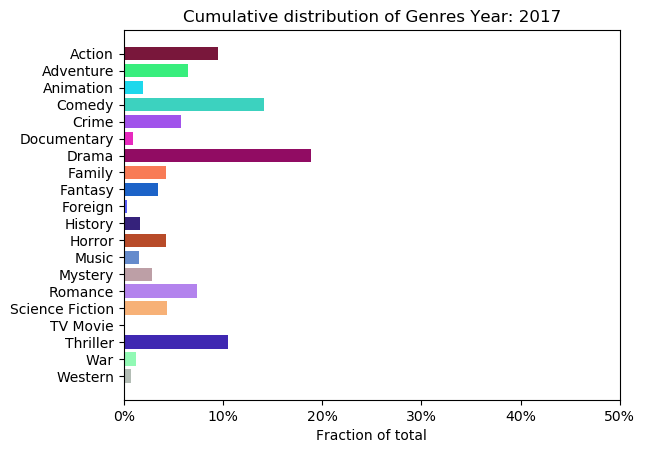

In [282]:
# Multiple plots shown as a movie
%matplotlib inline
np.random.seed(19680801)
plt.rcdefaults()

fig, ax = plt.subplots()


#Cumulative plot
cumm = True

#Initial
y_pos = np.arange(len(genres))
colors = np.random.rand(len(genres),3)
#lazy init
labels_=[x[0] for x in sorted(data[2000].items(), key = lambda x: x[0], reverse = True)]

#Plot each year
cumm_data=np.zeros(len(labels_))
for year in data.keys():    
    performance = np.array([x[1] for x in sorted(data[year].items(), reverse = True)])
    labels_ = [x[0] for x in sorted(data[year].items(), key = lambda x: x[0], reverse = True)]
    
    cumm_data+=performance
    
    if cumm:
        performance=cumm_data
    performance = performance / performance.sum()    
    
    plt.barh(y_pos, performance, align='center', color=colors)
    plt.xlabel('Fraction of total')
    plt.yticks(y_pos,labels_)
    plt.xticks([x for x in np.arange(0,11) / 10])
    plt.xlim(0,.5)
    plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0%}'))
    
    plt.title(f"Cumulative distribution of Genres Year: {year}")
    plt.show()
    time.sleep(0.1)
    clear_output(wait=True)

<b> Drama dominates </b> <br>
From the above plot we see that drama seems to have been the main genre since the begining of the dataset. When at its lowest, it still dominates around 20% of all the movies produced.

<b> The rise of thriller and comedy </b> <br>
From the 1990s and onwards, we see the rise in popularity of especially comedy and thrillers. This might be due to the rise of sitcoms such as Friends and Seinfield, which might also have brought the genres into the movie theaters. <br> 

To support this hypotesis, we investigate the development in genre budgets over time.

<b> Budget development </b>

In [283]:
df['year'] = df['release_date'].apply(lambda x: pd.to_datetime(x).year)

In [284]:
budgets = pd.concat(objs = [df[['budget', 'year']], df['genres'].apply(lambda x: '|'.join([y['name'] for y in json.loads(x)])).str.split('|', expand = True).fillna('')], ignore_index = True, axis = 1)
budgets = budgets.melt(id_vars = [0,1])
budgets.rename(columns = {0: 'budget', 1: 'year', 'value': 'genre'}, inplace = True)
budgets = budgets[['year', 'genre', 'budget']]

budgets = budgets[(budgets['genre'] != '') & (budgets['budget'] != 0)]
budgets['decade'] = budgets['year'].apply(lambda x: '{:.0f}s'.format(np.floor(x/10)*10))

In [285]:
g = budgets.groupby(['decade', 'genre'])['budget'].sum().unstack().fillna(0)
g = g.div(g.sum(axis=1), axis=0)

In [286]:
print()
print("Budget for genres as proportion of total")
print('----------------------------------------')
g.T.applymap(lambda x: '{:.0%}'.format(x))


Budget for genres as proportion of total
----------------------------------------


decade,1910s,1920s,1930s,1940s,1950s,1960s,1970s,1980s,1990s,2000s,2010s
genre,,,,,,,,,,,
Action,0%,0%,9%,1%,6%,10%,15%,16%,14%,13%,16%
Adventure,0%,0%,7%,2%,5%,7%,14%,15%,10%,12%,15%
Animation,0%,0%,3%,6%,0%,0%,0%,0%,2%,4%,5%
Comedy,0%,0%,8%,2%,6%,5%,6%,10%,10%,11%,10%
Crime,0%,0%,0%,2%,1%,3%,2%,5%,6%,5%,4%
Documentary,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%
Drama,100%,50%,22%,26%,32%,24%,13%,11%,14%,12%,10%
Family,0%,0%,7%,9%,0%,4%,4%,2%,4%,7%,7%
Fantasy,0%,0%,7%,3%,0%,1%,4%,6%,5%,6%,8%


What we see above is a sharp increase in the budget of thriller and comedy movies from 1950s and onward. The proportion is decreasing a bit around the 1990s but still remains high compared to the whole period.

#### Patterns of actors work within genres

Now that the general patterns of genre has been unraveled, we can take a look how it evolves on the a selected few actors to see if we can also spot a change in the actors genre distribution pr. year around the turn of the decade.

If we see a change around this point for the two genres to becomes more popular around it would indicate that the industry is transitioning into more focus on these genres. Alternatively, it could be due to a lot of new talent emerging into the market in primarly these genres.

## <span style="color:red">Insert Asbjørns plots on actor development</span>

### Important words of the decade
Now that we have a good idea of how the network has evolved and what genres are the dominant ones, let's take the initial steps to look if we can regonize the characteristics of the decades through the use of TF-IDF. <br>

* Do the most important words resemble the genre distribution? 
* How does it look when we relate the decade to what is happening in the world? ---- Senere ??
* Do the dominant elements from the genres correspond to what we expect?


#### TF-IDF calculation
The term TF-IDF is short for term frequency–inverse document frequency[\[2\]](https://en.wikipedia.org/wiki/Tf%E2%80%93idf)

TF-IDF is a statistical measure for the importance of a word in a document or corpus. The goal of using this statistical measure is to identify themes or elements of importance within pieces of text. We aim to apply this measure to movie descriptions from each decade to get an idea of the predominant subjects.


#### Calculation of TF-IDF
The calculation of TF-IDF can be done in many ways. Examples of TF are:

* >Boolean "frequencies": tf(t,d) = 1 if t occurs in d and 0 otherwise;
* > Term frequency adjusted for document length: tf(t,d) = ft,d ÷ (number of words in d)
* > Logarithmically scaled frequency: tf(t,d) = log (1 + ft,d);
* > Augmented frequency, to prevent a bias towards longer documents\[2\]

In our example, lengths of movie descriptions are fairly similar in length, so we use the raw count as term frequency.

For the IDF the $log(1+\frac{N}{1+n_t})$ was choosen, as it is a common choice with the $+1$ in the denominator ensuring not division by zero and the other +1 ensuring that the domain of the function is larger than $1$

#### Documents and Collections
As mentioned earlier the TF-IDF measure is a measure for a single document in a corpus. The problem has been modelled in the following way:
* The documents $ D $ are the joined overview for the given segmentation - movie descriptions for each decade in this case 
* The collection $ C $ is the joined documents for all the movie descriptions in the  **dataset/corpus**

<b> A note on stopwods </b> <br>
Stopwords generally contribute very little to the meaning of a document. We choose to remove stopwords alltogether.

We start off by creating helperfunctions to assist in the data loading process

In [95]:
import itertools

In [96]:
def load_segmented_documents(dataf, start_year:int, segment_years:int)-> defaultdict:
    decades = np.arange(1910,2020,10)
    '''
    Function to load the movie descriptions for a given decade
    '''
    subset = dataf[(dataf['year'] >=  start_year) & (dataf['year'] < start_year + segment_years)]
    document_words = subset['overview'].apply(lambda x: str(x).split(' ')).tolist()
    
    collection = []
    for d in decades:
        if d != start_year: #Omit document from corpus
            subset = dataf[(dataf['year'] >=  d) & (dataf['year'] < d + segment_years)]
            collection.append(list(itertools.chain(*subset['overview'].apply(lambda x: str(x).split(' ')).tolist())))
    
    return list(itertools.chain(*document_words)), collection

        
def calculate_tf_idf(document: list, collection: list):
    '''
    Function to calculate the TF-IDF measure of a given document
    Returns: A dictionary of words and their TF-IDF score
    '''
    # Naive count
    tf = Counter(document)
    # other variations
    #for k in tr: tr[k] = math.log10(tr[k]+1)
    #for k in tr: tr[k] /= len(document)
    
    # IDF
    N=len(collection)
    
    # Flattens data
    idf = defaultdict(int)
    for d in collection:
        words = set(d)
        for x in words:
            idf[x]+=1
    
    # Calculate IDF from n and n_t
    for k in idf: idf[k] = math.log(1+ N/(idf[k]+1))
    tfidf={k:tf[k]*idf[k] for k in tf}
    
    return tfidf

def tokenize(text:str, remove_stop_words=True)-> list:
    tokenized = [word.lower() for word in nltk.word_tokenize(text) if word.isalpha()]
    if remove_stop_words:
        stop_words = set(stopwords.words('english'))
        tokenized = [x for x in tokenized if x not in stop_words]
    return tokenized


In [97]:
#Calculate sentiment for each decade
decades = np.arange(1910,2020, 10)
print(decades)

[1910 1920 1930 1940 1950 1960 1970 1980 1990 2000 2010]


In [98]:
tfidf = dict()

for d in decades:
    #Load documents
    doc, collection = load_segmented_documents(df,d,10)
    #Tokenize
    doc = tokenize(' '.join(doc))
    collection = [tokenize(' '.join(x)) for x in collection]
    tfidf[d] = calculate_tf_idf(doc, collection)

Lets take a look at the first decade in our list and see what we find and if it relates to what we would expect for that decade

In [99]:
tfidf.keys()

dict_keys([1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010])

In [100]:
y=[x for x in tfidf.keys()][6]
print(f"The first decade in our data is {y}\n")
top_x=10
print(f"The top {top_x} most important words found by idf are:")
for x in [x[0] for x in sorted(tfidf[1970].items(), key=lambda x: x[1], reverse=True)[0:top_x]]:
    print(x)
top_movies=7
print(f"\nThe top {top_movies} grossing movies this decade was:")
df['decade']=df['release_date'].apply(lambda x: int(x.year/10)*10 if not pd.isna(x) else x)
print(df[df['decade']==y].sort_values('budget',ascending=False)[['original_title','budget']][0:top_movies])
print(f"\nThe top {top_movies} rated movies this decade was:")
print(df[df['decade']==y].sort_values('vote_average',ascending=False)[['original_title','vote_average']][0:top_movies])

The first decade in our data is 1970

The top 10 most important words found by idf are:
war
world
corleone
life
one
group
space
crew
planet
new

The top 7 grossing movies this decade was:
                     original_title    budget
813                        Superman  55000000
1367  Star Trek: The Motion Picture  35000000
1403             The Bad News Bears  35000000
1510                           1941  35000000
1531                      Moonraker  34000000
1525                 Apocalypse Now  31500000
1877              Tora! Tora! Tora!  25485000

The top 7 rated movies this decade was:
                       original_title  vote_average
3337                    The Godfather           8.4
2731           The Godfather: Part II           8.3
3719  One Flew Over the Cuckoo's Nest           8.2
2912                        Star Wars           8.1
4337                      Taxi Driver           8.0
1525                   Apocalypse Now           8.0
3158                            Alien  

In [102]:
def plot_decade_from_tfidf(year:int, tfidf:dict, top_x_words=100):
    text =' '.join([(x[0]+" ")*(int(1+x[1])) for x in sorted(tfidf[year].items(), key=lambda x: x[1], reverse=True)[0:top_x_words]]).replace('  ',' ')
    if str(year) not in [x.split('.')[0] for x in os.listdir()]:
        print(f"no mask found for this year{year}")
        raise Exception("Don't use this function")
    mask = np.array(Image.open(f'{year}.png'))
    image_colors = ImageColorGenerator(mask)
    wc = WordCloud(collocations=False,background_color="white", max_words=1000, mask=mask).generate(text)
    plt.figure(figsize=[12,12])
    plt.imshow(wc.recolor(color_func=image_colors), interpolation="bilinear")
    plt.axis("off")
    plt.show()

Let us try and plot the Wordclouds for the different decades

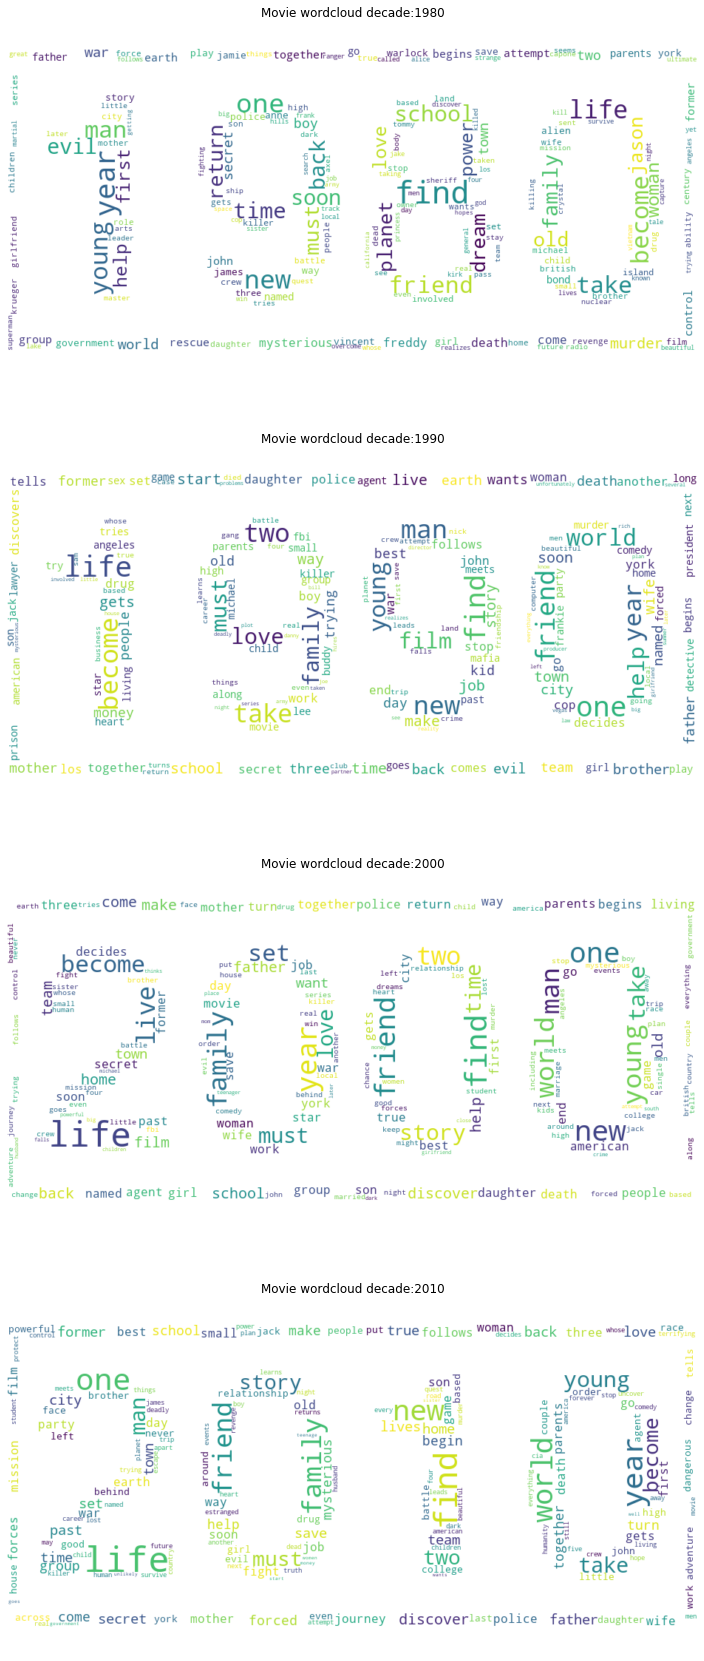

In [103]:
%matplotlib inline
nr=len(decades[-4:])
nc=1
fig, ax = plt.subplots(nrows=nr,ncols = nc, figsize=(25,30))
idx=0
year_keys = [x for x in tfidf.keys()]
top_words = 200

for i, d in enumerate(decades[-4:]):
    text =' '.join([(x[0]+" ")*(int(1+x[1])) for x in sorted(tfidf[d].items(), key=lambda x: x[1], reverse=True)[0:top_words]]).replace('  ',' ')
    if str(d) not in [x.split('.')[0] for x in os.listdir()]:
        print(f"no mask found for this year{d}")
        raise Exception("Don't use this function")

    mask = np.array(Image.open(f'{d}.png'))
    image_colors = ImageColorGenerator(mask)
    #Movies
    wc = WordCloud(collocations=False,background_color="white", max_words=1000, mask=mask).generate(text)
    ax[i].imshow(wc, interpolation="bilinear")
    ax[i].set_title(f'Movie wordcloud decade:{d}')
    ax[i].axis("off")


plt.show()

In general, it is difficult very characteristic words of each decade of movie descriptions. All of them seem to contain somehow descriptive words like "man", "woman", "home" etc. However, a few points stand out:

* 1980s: Evil, Capone, Krueger, family, life and dream
* 1990s: Stop, drug, FBI, war, cop, love, family, world
* 2000s: Life, friend, young, family, father
* 2010s: Life, friend, party, love, parents, world

A bold statement is that action type movies was more dominant in the first two decades, whereas family-type movies got more presence in the later decades.

Lets up look into a subset of the previous analysis of movie budgets per decade and genre:

In [104]:
g.iloc[-4:][['Action', 'Family']].applymap(lambda x: '{:.0%}'.format(x))

genre,Action,Family
decade,,
1980s,16%,2%
1990s,14%,4%
2000s,13%,7%
2010s,16%,7%


As we see from the above, the action genre remained fairly constant while the family genre almost quadrupled its proportion of budget from 1980s to 2010s. This might partly explain the more "family" toned words we see today.

But what about within a single genre? We earlier noticed that there was a development within the popularity of the comedy genre, can we also spot a change in the words?


In [105]:
# Get only comedy movies
df_comedy = df[df['genres'].apply(lambda x: True if not pd.isna(x) and ('Comedy' in [y['name'] for y in json.loads(x)]) else False)]
df_comedy=df_comedy.reset_index()
# Extracting the data from 1970 with 10 year segments
docs=load_segmented_documents(df_comedy,1970,10)
collection=[tokenize(v) for v in docs.values()]

tfidf=dict()
for year_segment, text in docs.items():
    tfidf[year_segment]=calculate_tf_idf(tokenize(text), collection)

AttributeError: 'tuple' object has no attribute 'values'

In [106]:
list_for_df=[]
for y in [x for x in tfidf.keys()]:
    top_x=5
    temp_list=[]
    for idx, x in enumerate([x[0] for x in sorted(tfidf[y].items(), key=lambda x: x[1], reverse=True)[0:top_x]]):
        temp_list.append([y,x,idx+1])
    list_for_df.append(temp_list)
pd.DataFrame([y for x in list_for_df for y in x],columns=['Decade','Word','Rank']).pivot(index='Decade', columns='Rank', values='Word')

Rank,1,2,3,4,5
Decade,,,,,
1910,interwoven,prejudice,tales,throughout,separated
1920,queenie,harriet,class,jock,love
1930,monte,roger,war,roy,helen
1940,pinocchio,mill,pete,family,life
1950,solomon,film,polly,egypt,rose
1960,bond,film,life,war,man
1970,war,world,corleone,life,one
1980,one,new,life,young,man
1990,life,one,two,man,new


### <span style="color:red">COMMENTS ON DEVELOPMENT IN COMEDY GENRE</span>


### <span style="color:red">WRAP UP TF-IDF</span>


<b> On TF-IDF for movie description </b> <br>
In general, the tf-idf procedure worked well on movie description. When it comes to deducing meaningful conclusions on the decades, one has to be a bit creative. How about trying to analyze the sentiment of the movie descriptions? <br>

<u> Can we detect the family-oriented development from the 1980s towards the 2010s? </u>

## Mood of the Town - Sentimenthistory
Now we have seen which words characterizes the decades through the TF-IDF analysis. <br> Exploring this further, what can the sentiment of the movie descriptions tell us? <br> <br>

We investigate whether we can detect changes in sentiment over time. and does it change within the genres?

Boldly stated, this will allow us to infer the <i> mood of hollywood </i> and partly wield us to answer the question:
<i> Does the movie production of hollywood reflect the mood of the general state of the world? </i>

<b> On sentiment analysis </b> <br>
To do this sentiment analysis we utilize the labMT dataset [\[3\]](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0026752) which is a "language assessment by Mechanical Turk (labMT) word list to score the happiness of a corpus. The labMT word list was created by combining the 5000 words most frequently appearing in four sources: Twitter, the New York Times, Google Books, and music lyrics, and then scoring the words for sentiment on Amazon’s Mechanical Turk" [\[4\]](https://buildmedia.readthedocs.org/media/pdf/labmt-simple/latest/labmt-simple.pdf)

### Important considerations

**1) Not using a lemmatizer**

The project avoids using a lemmatizer because words such as "armed" or "arm", which are stemmed to "arm", does not have the same meaning nor the same sentiment associated to it. The same argument goes for words that are stemmed to be equal (part of lemmatization: "have" and "had" can have different sentiments.

**2) Stop words**
In assignment 2 of this course, we investigated the sentiment of stop words which revealed that some stop words are non-neutral, and thus the project will not remove stop words from the texts.

**3) Removing netrual words** <br>
A neutral word has a score of 5, and as stated in the article **Temporal Patterns of Happiness and Information in a Global Social Network[\[3\]](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0026752)**, it makes sense to get rid of all the neutral words, because they reveal little about the happiness of a text. Thus we remove all words with a happiness average between 6 and 4.
This means we choose $\Delta h_{avg} = 1$, and remove all words that lies $h_{avg}$ within the neutral score of 5, that is, $5-h_{avg}<h_{avg}<5+h_{avg}$.

We will start out by creating the foundation for the sentiment analysis by loading in the data set from the supplemntary material in [\[3\]](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0026752). We filter the data according to the described method above

In [ ]:
path = 'https://journals.plos.org/plosone/article/file?id=10.1371/journal.pone.0026752.s001&type=supplementary'
#Read data
df_s = pd.read_csv(path, skiprows = 2, sep = '\t')

In [ ]:
df_s[["happiness_average", "happiness_standard_deviation"]] = df_s[["happiness_average", "happiness_standard_deviation"]].apply(pd.to_numeric)
df_s = df_s[(df_s['happiness_average']>6) | (df_s['happiness_average']<4)]

In [ ]:
df_s.head()

In [ ]:
#Dictionary to look up average hapiness for a given word
sentiment_lookup = df_s[['word', 'happiness_average']].set_index('word').to_dict()['happiness_average']
print("Example:")
print(list(sentiment_lookup.items())[:5])

We apply the following formula the sentiment sentiment for a decade of movie descriptions (and later a wiki page):

$$V_{text} = \frac{\sum \limits_k v_k f_k}{\sum \limits_k f_k}$$

This is the sum of sentiment of the words in the text with sentiment, divided by the number of words found with sentiment e.g. we disregard words with a sentiment scores.

In [ ]:
for d in decades:
    #Load documents
    doc, collection = load_segmented_documents(df,d,10)

In [ ]:
sentiment_decades = {}
for i, d in enumerate(decades):
    doc, _ = load_segmented_documents(df,d,10)
    doc = tokenize(' '.join(doc))
    sentiment_decades[d] = list(map(sentiment_lookup.get, doc))
    sentiment_decades[d] = [x for x in sentiment_decades[d] if x != None] #Remove words with no sentiment

In [ ]:
print("Example")
print("1990", sentiment_decades[1990][:10], "...")

As before we will take a look at a specific year again and take a look at it in depth, after wich we will aggregate the findings to more general level using all the segments (decades). The findings will then be discussed

In [ ]:
# Calculate sentiment for documents
decade_data = {k: tokenize(v) for k,v in docs.items()}
sentiment_decade_dict_aggregate, sentiment_decade_dict = calculate_sentiment_dict(decade_data)

We now have the calculations of sentiment from the decade segmentation of the movie industry let's take a look at it. Can we relate the sentiment to what we found in the word analysis?

In [ ]:
x = decades
y = [np.mean(sentiment_decades[d]) for d in decades]
yerr = [np.std(sentiment_decades[d]) for d in decades]

fig, ax = plt.subplots(figsize = (16,8))


ax.errorbar(x, y, yerr, ecolor ='r', fmt='-o', label = 'Sentiment')

ax.set_xlabel('Decades')
ax.set_xticks(decades)
ax.set_ylabel('Average sentiment')
ax.set_ylim(0,10)
ax.set_yticks(np.arange(0,11))
ax.legend()
plt.title('Average sentiment over the decades (with standard deviation)')
plt.show()

From the above plot it seems like hollywood have a slight positive sentiment. The standard deviation in the sentiment of each decade is very high which makes it difficult to assign meaning to the slight changes over time.

<b> The world is getting better </b>
In a 2018 Vox posted 23 statistical measures that shows that the world is getting better such as decreasing infant mortality rate and declining hunger [\[6\]](https://www.vox.com/2014/11/24/7272929/global-poverty-health-crime-literacy-good-news) - maybe the mood in hollywood is too. 

<b> The genre outbalances </b> <br>
The close to netrual (i.e sentiment around $5$) makes any conclusions difficult. A possible explanation for this, though, might be that genres "even out" each other. This means that "positive" genres such as comedy and family might be evened out by "horror" and "thriller" movies.


<i> A note on the sentiment assignments </i> <br>
Note that segment scores are evaluated in 2010/11, and therefore might not be very accurate for 1970 as the meaning of words and values tend to change over time.

<u> Let us check the hypothesis on the fact than genres might outbalance each other </u>

In [ ]:
#Identify movies
horror_thriller_movies = df[df['genres'].apply(lambda x: 'horror' in str(x).lower() or 'thriller' in str(x).lower())]
family_comedy_movies = df[df['genres'].apply(lambda x: 'comedy' in str(x).lower() or 'family' in str(x).lower())]

In [ ]:
#Calculate sentiment of the movies of the genres
horror_thriller_text = tokenize(' '.join(horror_thriller_movies['overview']))
family_comedy_text = tokenize(' '.join(family_comedy_movies['overview']))

sentiment_horror = list(map(sentiment_lookup.get, horror_thriller_text))
sentiment_horror = [x for x in sentiment_horror if x != None] #Remove words with no sentiment

sentiment_family = list(map(sentiment_lookup.get, family_comedy_text))
sentiment_family = [x for x in sentiment_family if x != None] #Remove words with no sentiment

print("Example of horror sentiment")
print(sentiment_horror[:10])

Let us plot the distribution of sentiment

NameError: name 'sentiment_horror' is not defined

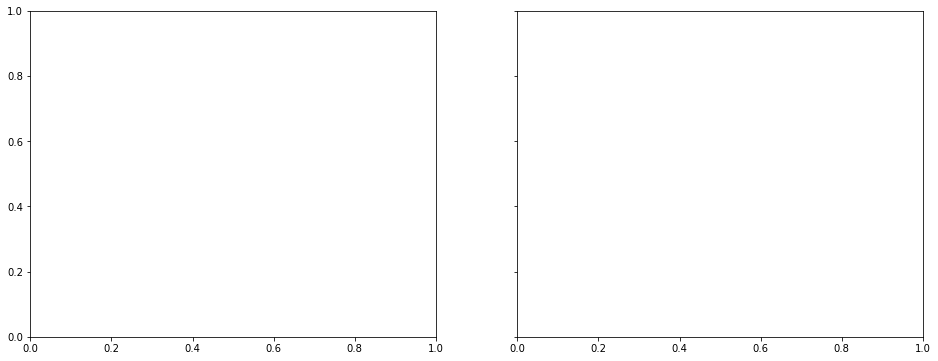

In [56]:
fig, ax = plt.subplots(ncols = 2, figsize = (16,6), sharex = True, sharey = True)


ax[0].hist(sentiment_horror, normed=1)
ax[1].hist(sentiment_family, normed=1)
ax[0].set_title('Horror/Thriller')
ax[1].set_title('Family/Comedy')

ax[0].set_ylabel('Number of tokens')
ax[0].set_xlabel('Sentiment')
ax[1].set_xlabel('Sentiment')

ax[0].grid(True)
ax[1].grid(True)

plt.suptitle('Distribution of sentiment', fontsize = 18)
plt.show()

From the above plot, we see that Family and Comedy movis definitely tends to have a higher sentiment than those of horror and thriller movies. <br> <b> This supports out hypothesis that genres might balance out the sentiment </b>

**Summarizing** <br>
The sentiment analyses showed that Hollywood tends to have slightly positive sentiment in their movie descriptions, however not by much. It was seen that the standard deviation of the sentiments over the decades were too high to conclude on changes over time. <br>

Furthermore, we checked the hypothesis that genres might <i> balance out sentiment </i> (e.g Thriller vs. Comedy). We checked that hypothesis and saw that comedy and family movies definitely have a higher sentiment than that of thriller and horror movies. <br>

# <span style="color:red">Final thoughts</span>
